<a href="https://colab.research.google.com/github/sp-au-mu-nl/PythonMedia/blob/main/notebook/chap12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/sp-au-mu-nl/PythonMedia/raw/refs/heads/main/data/chap12.zip
!unzip chap12.zip
!rm chap12.zip

--2025-06-26 07:20:23--  https://github.com/sp-au-mu-nl/PythonMedia/raw/refs/heads/main/data/chap12.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sp-au-mu-nl/PythonMedia/refs/heads/main/data/chap12.zip [following]
--2025-06-26 07:20:23--  https://raw.githubusercontent.com/sp-au-mu-nl/PythonMedia/refs/heads/main/data/chap12.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12399203 (12M) [application/zip]
Saving to: ‘chap12.zip’

chap12.zip          100%[===================>]  11.82M  78.5MB/s    in 0.2s    

2025-06-26 07:20:24 (78.5 MB/s) - ‘chap12.zip’ saved [12399203/12399203]

Archiv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import numpy.matlib
from scipy.io import savemat,loadmat
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import librosa
import IPython

In [3]:
%%writefile adsr1.py
import numpy as np
from scipy import signal

def adsr1(env,fs):
  r,c=env.shape
  ADSR=np.array([])
  pre=0
  for k in range(r):
    ADSR=np.concatenate((ADSR[0:-1],
                         np.linspace(pre,env[k,2],
                                     int((env[k,1]-env[k,0])/(1/fs)))))
    pre=env[k,2]
  return(ADSR)

Writing adsr1.py


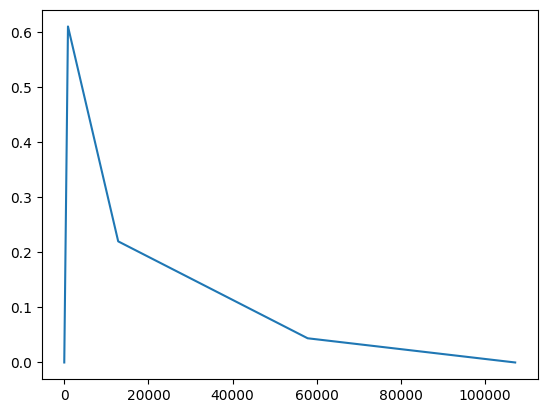

In [4]:
from adsr1 import adsr1
y,fs=librosa.load('piano.wav',sr=None)
fmt=np.array([[0,0.02,0.61],
              [0.02,0.29,0.22],
              [0.29,1.31,0.044],
              [1.31,2.43,0]])
plt.plot(adsr1(fmt,fs))

In [5]:
ADSR=adsr1(fmt,fs)
sq=signal.square(2*np.pi*220*np.arange(0,ADSR.shape[0])/fs)
IPython.display.Audio(sq*ADSR,rate=fs)

In [6]:
IPython.display.Audio(y,rate=fs)

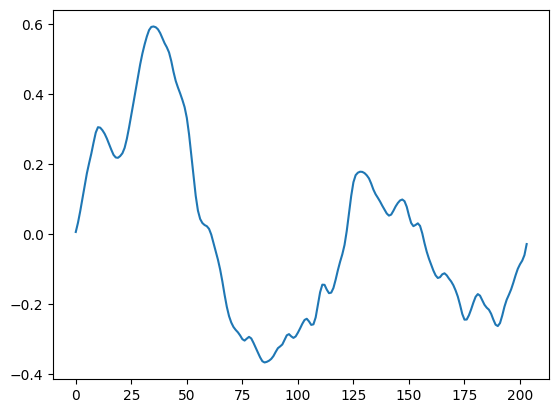

In [7]:
a=y[8859:9063]
plt.plot(a)

In [8]:
wnum=int(np.ceil(ADSR.shape[0]/a.shape[0]))
yy=np.matlib.repmat(a,1,wnum)
IPython.display.Audio(yy[0,:ADSR.shape[0]]*ADSR,rate=fs)

In [9]:
%%writefile wavetable_synth1.py
import numpy as np
import numpy.matlib
from adsr1 import adsr1

def wavetable_synth1(table,env,fs):
  period,ntemplate=table.shape
  nframe1=int(np.floor((env[0,1]-env[0,0])*fs/period))
  nframe2=int(np.floor((env[1,1]-env[1,0])*fs/period))
  nframe=min(nframe1,nframe2)
  ntrans=int(np.floor(nframe/2))
  up=np.linspace(0,1,ntrans*2*period)
  down=np.linspace(1,0,ntrans*2*period)
  wave=np.matlib.repmat(table[:,0],1,nframe1-ntrans)[0]
  for k in range(ntemplate-2):
    pre=np.matlib.repmat(table[:,k],1,ntrans*2)[0]*down
    cur=np.matlib.repmat(table[:,k+1],1,ntrans*2)[0]*up
    wave=np.hstack((wave,pre+cur))
    nframe1=nframe2
    nframe2=int(np.floor((env[k+2,1]-env[k+2,0])*fs/period))
    nframe=min((nframe1-ntrans)*2,nframe2)
    ntrans_prev=ntrans
    ntrans=int(np.floor(nframe/2))
    up=np.linspace(0,1,ntrans*2*period)
    down=np.linspace(1,0,ntrans*2*period)
    cur=np.matlib.repmat(table[:,k+1],1,nframe1-ntrans-ntrans_prev)[0]
    wave=np.hstack((wave,cur))
  k=k+1
  pre=np.matlib.repmat(table[:,k],1,ntrans*2)[0]*down
  cur=np.matlib.repmat(table[:,k+1],1,ntrans*2)[0]*up
  wave=np.hstack((wave,pre+cur))
  cur=np.matlib.repmat(table[:,k+1],1,nframe2-ntrans)[0]
  wave=np.hstack((wave,cur))
  ADSR=adsr1(env,fs)
  wave_end=min(ADSR.shape[0],wave.shape[0])
  return(wave[:wave_end]*ADSR[:wave_end])

Writing wavetable_synth1.py


In [10]:
waves=[y[8859:9063],
       y[11479:11679],
       y[23700:23901],
       y[60024:60224]]
period=int(np.fix(fs/220))
table=np.zeros((period,4))
for k in range(table.shape[1]):
  table[:,k]=signal.resample_poly(waves[k],period,waves[k].shape[0])
table=table-np.mean(table,axis=0)
table=table/np.max(np.abs(table),axis=0)
savemat('piano1.mat',{'table':table,'fs':fs,'env':fmt})

In [11]:
from wavetable_synth1 import wavetable_synth1
pdata=loadmat('piano1.mat')
type(pdata)

dict

In [12]:
pdata['fs']

array([[44100]])

In [13]:
fs=pdata['fs'][0][0]
IPython.display.Audio(wavetable_synth1(pdata['table'],pdata['env'],fs),rate=fs)

In [14]:
env120_4=np.array([[0,0.02,0.61],
                   [0.02,0.29,0.22],
                   [0.29,0.40,0.044],
                   [0.40,0.5,0]])
IPython.display.Audio(wavetable_synth1(pdata['table'],env120_4,fs),rate=fs)

In [15]:
table2=signal.resample_poly(pdata['table'],1,2)
IPython.display.Audio(wavetable_synth1(table2,pdata['env'],fs),rate=fs)

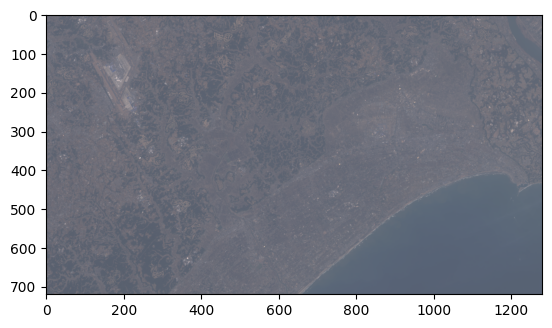

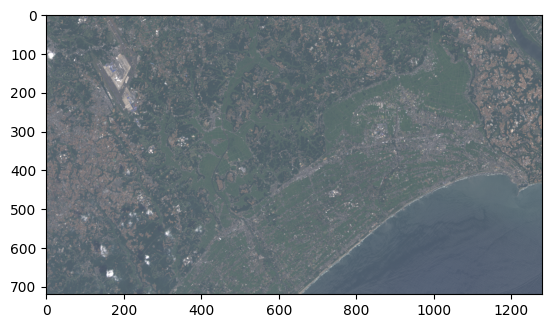

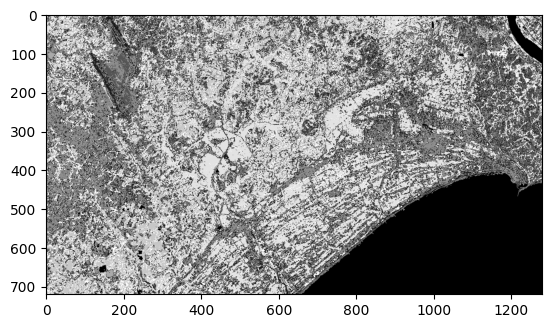

In [16]:
B1=cv2.imread('20140312_B4.pgm',-1)
h,w=B1.shape
X=np.zeros((h,w,4))
X[:,:,0]=B1
X[:,:,1]=cv2.imread('20140312_B3.pgm',-1)
X[:,:,2]=cv2.imread('20140312_B2.pgm',-1)
X[:,:,3]=cv2.imread('20140312_B5.pgm',-1)
Y=np.zeros((h,w,4))
Y[:,:,0]=cv2.imread('20140803_B4.pgm',-1)
Y[:,:,1]=cv2.imread('20140803_B3.pgm',-1)
Y[:,:,2]=cv2.imread('20140803_B2.pgm',-1)
Y[:,:,3]=cv2.imread('20140803_B5.pgm',-1)
plt.imshow(np.uint8(np.clip(X[:,:,0:3]/np.max(X)*256*3,0,255)))
plt.figure()
plt.imshow(np.uint8(np.clip(Y[:,:,0:3]/np.max(X)*256*3,0,255)))
Z=np.hstack((X.reshape((h*w,4)),Y.reshape((h*w,4))))
c=KMeans(n_clusters=10).fit(Z)
plt.figure()
plt.imshow(((c.labels_+1)*25).reshape((h,w)),cmap='gray')

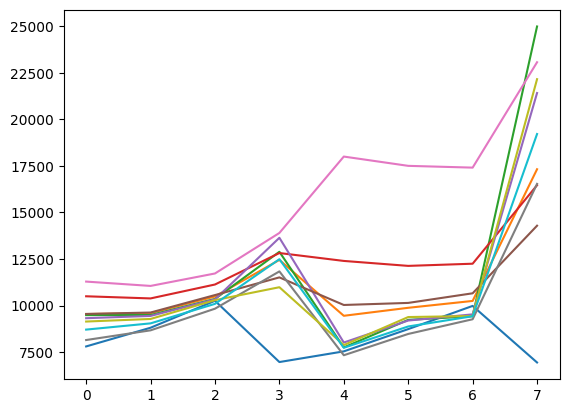

In [17]:
plt.plot(c.cluster_centers_.T)

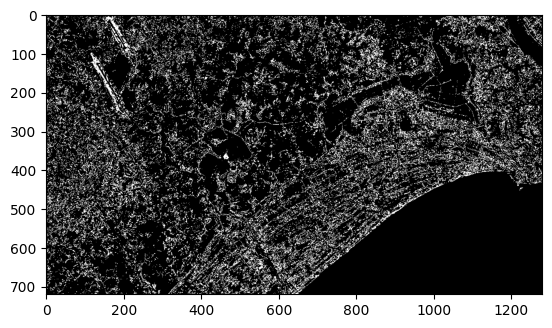

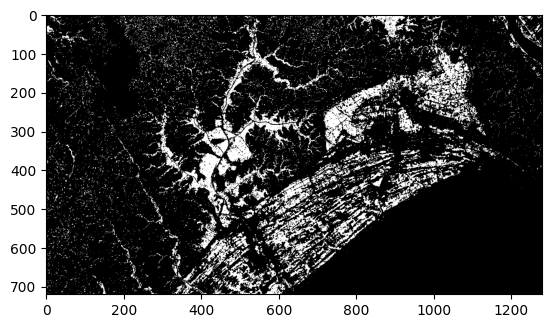

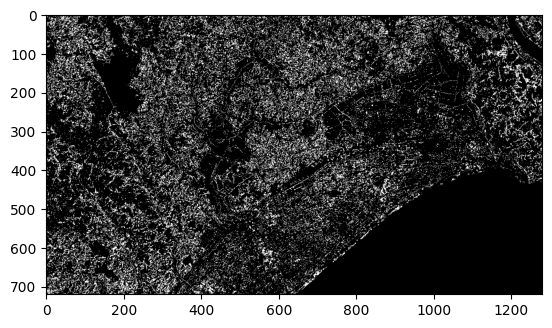

In [18]:
plt.figure(); plt.imshow((c.labels_==1).reshape((h,w)),cmap='gray')
plt.figure(); plt.imshow((c.labels_==8).reshape((h,w)),cmap='gray')
plt.figure(); plt.imshow((c.labels_==9).reshape((h,w)),cmap='gray')

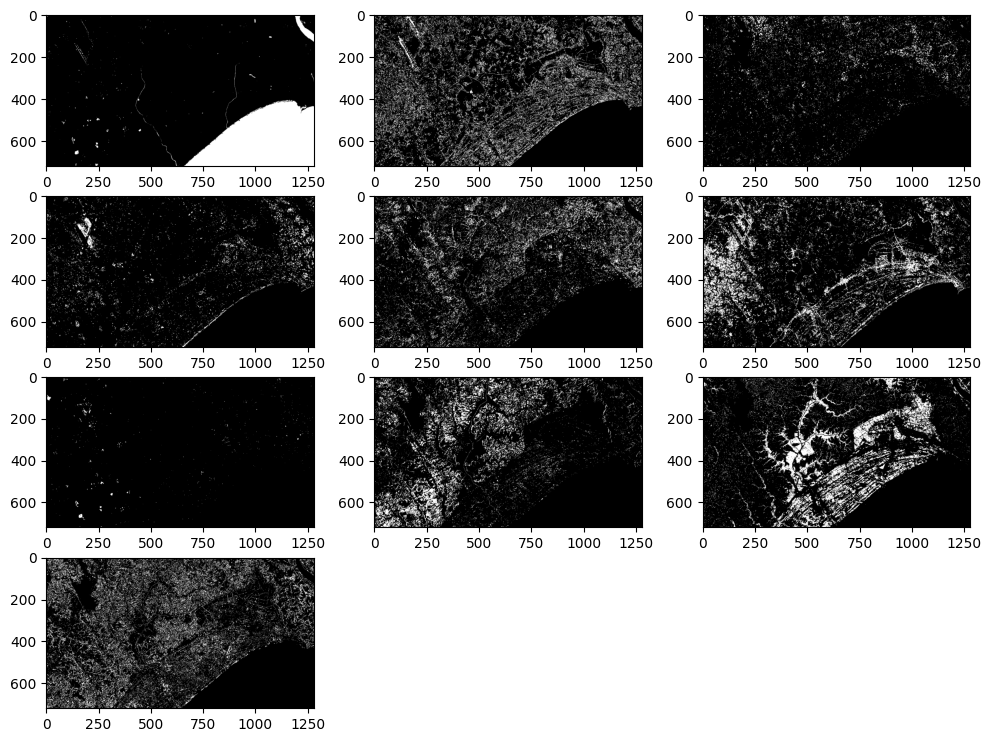

In [19]:
plt.figure(figsize=(12,9))
plt.subplot(4,3,1); plt.imshow((c.labels_==0).reshape((h,w)),cmap='gray')
plt.subplot(4,3,2); plt.imshow((c.labels_==1).reshape((h,w)),cmap='gray')
plt.subplot(4,3,3); plt.imshow((c.labels_==2).reshape((h,w)),cmap='gray')
plt.subplot(4,3,4); plt.imshow((c.labels_==3).reshape((h,w)),cmap='gray')
plt.subplot(4,3,5); plt.imshow((c.labels_==4).reshape((h,w)),cmap='gray')
plt.subplot(4,3,6); plt.imshow((c.labels_==5).reshape((h,w)),cmap='gray')
plt.subplot(4,3,7); plt.imshow((c.labels_==6).reshape((h,w)),cmap='gray')
plt.subplot(4,3,8); plt.imshow((c.labels_==7).reshape((h,w)),cmap='gray')
plt.subplot(4,3,9); plt.imshow((c.labels_==8).reshape((h,w)),cmap='gray')
plt.subplot(4,3,10); plt.imshow((c.labels_==9).reshape((h,w)),cmap='gray')

In [20]:
class Inst():
  def __init__(self,fs):
    self.fs=fs

piano=Inst(fs)
piano.table=table
piano.env=fmt
1/(piano.table.shape[0]/piano.fs)

np.float64(220.5)

In [21]:
piano.pitch=57
sound=piano
sound.pitch

57